# Testing Code and timing benchmark code for train_invC.ipynb
Compares the timing performance of direct regression CNN and (possibly) loaded matlab EP recon results.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from unet_layers import *
import h5py
from torch.utils.data import DataLoader
from torchvision import transforms as T
from tensorboardX import SummaryWriter
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from data_utils import FSdataset_h5,my_paired_RandomCrop,my_paired_normalize, my_paired_gamma_correction
from visualize import show_FS,show_EPI_xu,show_EPI_yv,show_SAI
from torch.optim.lr_scheduler import MultiStepLR
from scipy.io import loadmat
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="0"
np.random.seed(100);
torch.manual_seed(100);
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False #Setting to True may leads to faster but undeterminsitc result.

In [2]:
#bs_train = 2
bs_val = 1 # Use 1 is recommended for properly calculating average PSNR
nF=7
lfsize = [185, 269, 7, 7] #H,W,v,u
#dimensions of Lytro light fields, H,W,nv,nu. 
#Note original Lytro LF has dimension 376X541 X 14 X 14, the paper takes only first 372/540 spatial pixel and central 8 by 8 SAI
#which is being followed here

#transform_train = T.Compose([my_paired_normalize({'FS':9000,'LF':1})]) #Since FS is not normalized in matlab and LF is normalized already to [0,1]
transform_val = T.Compose([my_paired_normalize({'FS':9000,'LF':1})])

#ds_train = FSdataset_h5(FSdata_path='/home/zyhuang/EVO970Plus/FS_dataset/FS_dmin_-1_dmax_0.3_nF_7_inverseCrime.h5',LFdata_path='/home/zyhuang/EVO970Plus/LF_dataset/FS_dmin_-1_dmax_0.3_nF_7_inverseCrime.h5',trainorval='train',transform = transform_train)
ds_val =  FSdataset_h5(FSdata_path='/home/zyhuang/EVO970Plus/FS_dataset/FS_dmin_-1_dmax_0.3_nF_7_inverseCrime.h5',LFdata_path='/home/zyhuang/EVO970Plus/LF_dataset/FS_dmin_-1_dmax_0.3_nF_7_inverseCrime.h5',trainorval='val',transform = transform_val)

path = 'logs/Avoid_invcrime/FS_dmin_-1_dmax_0.3_nF_7/unet_FS2LF_v3_tanh/lr_5e-4_bs_train_2_bs_val_5/model.pth'

#train_loader=DataLoader(ds_train, batch_size=bs_train,shuffle=True, num_workers = 10,pin_memory = True)
val_loader=DataLoader(ds_val, batch_size=bs_val,shuffle=False, num_workers = 5,pin_memory = True)

In [3]:
net = unet_FS2LF_v3(nF=nF,nu=lfsize[3],nv=lfsize[2],box_constraint = 'tanh')
net.load_state_dict(torch.load(path))
criterion = nn.L1Loss()
#criterion = nn.MSELoss()
#scheduler = MultiStepLR(optimizer, milestones=[3,6,10,20], gamma=0.5)

def my_psnr(I,Iref,peakval):
    mse = ((I-Iref)**2).mean()
    return 10*torch.log10(peakval**2/mse)

In [4]:
dt = 0
#Calculate Full loss across entire val dataset every epoch
Full_output_loss = 0
Full_PSNR = 0
device = torch.device("cuda") #switch between cuda and cpu
net.to(device)
for idx,data in enumerate(val_loader,0):
    net.eval()
    t1 =time.time()
    FS,LF=data['FS'].to(device),data['LF'].to(device) 

    with torch.no_grad():
        reconLF=net(FS)
        loss=criterion(reconLF,LF)
        PSNR = my_psnr(reconLF,LF,1)
    t2 = time.time()
    dt += (time.time() -t1)
    print('Minibatch val_loss is:%.4f' %(loss.item()))
    print('Minibatch PSNR is:%.4f' %(PSNR.item()))
    Full_output_loss += loss.item()
    Full_PSNR += PSNR.item()

Full_output_loss = Full_output_loss/len(val_loader)# this assumes each batch has same size
Full_PSNR = Full_PSNR/len(val_loader)
Average_reconTime = dt/len(val_loader)
print('Average_reconTime is:%.4f s' %(Average_reconTime)) # use bs_val = 1! for timing
print('Full_output_loss is:%.4f' %(Full_output_loss))
print('Full_PSNR is:%.4f' %(Full_PSNR))


/home/zyhuang/anaconda3/envs/py36_pytorch04/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Minibatch val_loss is:0.0065
Minibatch PSNR is:39.3989
Minibatch val_loss is:0.0082
Minibatch PSNR is:38.4631
Minibatch val_loss is:0.0083
Minibatch PSNR is:36.7210
Minibatch val_loss is:0.0072
Minibatch PSNR is:37.7821
Minibatch val_loss is:0.0077
Minibatch PSNR is:37.4108
Minibatch val_loss is:0.0097
Minibatch PSNR is:35.9115
Minibatch val_loss is:0.0065
Minibatch PSNR is:40.1879
Minibatch val_loss is:0.0108
Minibatch PSNR is:34.5020
Minibatch val_loss is:0.0100
Minibatch PSNR is:35.8941
Minibatch val_loss is:0.0081
Minibatch PSNR is:38.7593
Minibatch val_loss is:0.0095
Minibatch PSNR is:36.3729
Minibatch val_loss is:0.0071
Minibatch PSNR is:39.3890
Minibatch val_loss is:0.0074
Minibatch PSNR is:35.3441
Minibatch val_loss is:0.0070
Minibatch PSNR is:38.3967
Minibatch val_loss is:0.0080
Minibatch PSNR is:37.6628
Minibatch val_loss is:0.0059
Minibatch PSNR is:41.2507
Minibatch val_loss is:0.0086
Minibatch PSNR is:34.1349
Minibatch val_loss is:0.0082
Minibatch PSNR is:39.3364
Minibatch 

# For generating timing comparision plot
The matlab EP recon timing need to be generated before hand by running iter_recon_EP.m using proper choice of reg parameters.

In [ ]:
EP_PSNRvsTime = loadmat('/media/WD/LF_recon/Result_FSNet_baseline/Val5_PSNRvsTime.mat')['PSNRvsTime']
dt_gpu = 0.0178 # Result from above 
dt_cpu = 0.24 # Result from above 

In [ ]:
t_gpu=np.arange(0,EP_PSNRvsTime[:,0].max(),dt_gpu)
t_cpu=np.arange(0,EP_PSNRvsTime[:,0].max(),dt_cpu)
PSNR_CNN_gpu = np.zeros_like(t_gpu)
PSNR_CNN_cpu = np.zeros_like(t_cpu)
PSNR_CNN_gpu[1:] = 37.955
PSNR_CNN_cpu[1:] = 37.955

plt.scatter(EP_PSNRvsTime[:,0],EP_PSNRvsTime[:,1])
plt.title('ReconLF average PSNR (first 5 test samples)')
plt.ylabel('PSNR (dB)')
plt.xlabel('Time (s)')


plt.plot()
plt.plot(t_gpu,PSNR_CNN_gpu)
plt.plot(t_cpu,PSNR_CNN_cpu)
plt.ylim([32,40])
plt.legend(['Unet_GPU ({:.4f} s)'.format(dt_gpu),'Unet_CPU ({:.4f} s)'.format(dt_cpu),'EP_recon_pcg'])
#plt.savefig('Timing compare.png')

# Generating Animation of the LF 

In [ ]:
import imageio

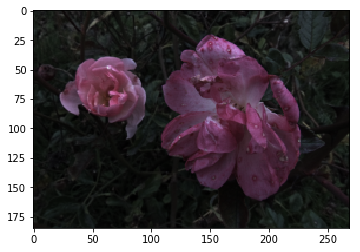

In [42]:
#Generate Camera moving grid
idx_v=[0,0,0,0,0,0,0,1,2,3,4,5,6,6,6,6,6,6,6,5,4,3,2,1,0]
idx_u=[0,1,2,3,4,5,6,6,6,6,6,6,6,5,4,3,2,1,0,0,0,0,0,0,0]

filenames_LFrecon=[]
filenames_trueLF=[]
for i in range(len(idx_u)):
    fig = plt.imshow(reconLF[0,:,idx_v[i],idx_u[i],:,:].cpu().detach().permute([1,2,0]))
    filename = '{:d}_{:d}_recon.png'.format(idx_v[i],idx_u[i])
    plt.savefig(filename)
    filenames_LFrecon.append(filename)
    
for i in range(len(idx_u)):
    fig = plt.imshow(LF[0,:,idx_v[i],idx_u[i],:,:].cpu().detach().permute([1,2,0]))
    filename = '{:d}_{:d}_true.png'.format(idx_v[i],idx_u[i])
    plt.savefig(filename)
    filenames_trueLF.append(filename)


In [43]:
images = []
for filename in filenames_LFrecon:
    images.append(imageio.imread(filename))
imageio.mimsave('LFrecon.gif', images)

images = []
for filename in filenames_trueLF:
    images.append(imageio.imread(filename))
imageio.mimsave('trueLF.gif', images)